In [4]:
from sklearn.linear_model import LassoCV
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split 

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df,name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name,x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


encode_text_dummy(df, 'origin')

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df,target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)

    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.int32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.float32)


# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45) 
        

Final score (RMSE): 2.9371569088396146


,coef,positive
origin-1,-1.448374,False
cylinders,-0.416546,False
horsepower,-0.007785,False
weight,-0.007473,False
displacement,0.024456,True
acceleration,0.138122,True
origin-3,0.629809,True
year,0.801274,True
origin-2,0.818566,True


Intercept: [-18.25753533]


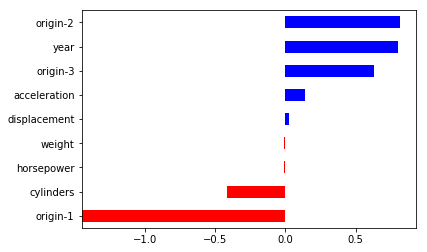

In [5]:
import sklearn
from sklearn import metrics
# Create linear regression
regressor = sklearn.linear_model.LinearRegression()

# Fit/train linear regression
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")

# Simple function to evaluate the coefficients of a regression
%matplotlib inline    
from IPython.display import display, HTML    

def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))

report_coef(
  names,
  regressor.coef_[0,:],
  regressor.intercept_)


Final score (RMSE): 3.0409047603607178


,coef,positive
origin-1,-1.264483,False
weight,-0.007458,False
horsepower,-0.002799,False
cylinders,-0.000000,True
origin-2,0.000000,True
origin-3,0.000000,True
displacement,0.013005,True
acceleration,0.113755,True
year,0.787194,True


Intercept: [-17.27110481]


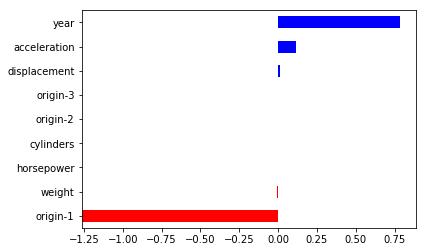

In [6]:
#L1 (Lasso) Regularization
import sklearn
from sklearn.linear_model import Lasso

# Create linear regression
regressor = Lasso(random_state=0,alpha=0.1)

# Fit/train LASSO
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")
report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)


Final score (RMSE): 2.9413154427467028


,coef,positive
origin-1,-1.420925,False
cylinders,-0.409651,False
horsepower,-0.007524,False
weight,-0.007473,False
displacement,0.024128,True
acceleration,0.137985,True
origin-3,0.619104,True
year,0.800769,True
origin-2,0.801821,True


Intercept: [-18.23057194]


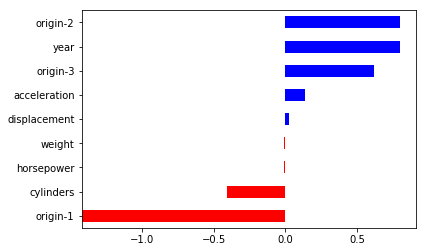

In [7]:
#L2 (Ridge) Regularization
import sklearn
from sklearn.linear_model import Ridge

# Create linear regression
regressor = Ridge(alpha=1)

# Fit/train Ridge
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")
report_coef(
  names,
  regressor.coef_[0,:],
  regressor.intercept_)

Score (RMSE): 2.740379810333252


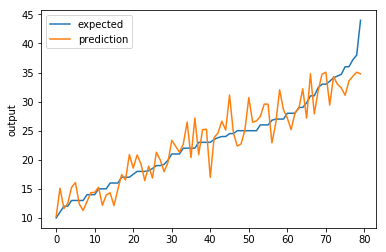

In [13]:
########################################
# TensorFlow with L1/L2 for Regression
########################################

%matplotlib inline
from matplotlib.pyplot import figure, show
import tensorflow.contrib.learn as learn
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
import shutil
import matplotlib.pyplot as plt

path = "./data/"


tf.logging.set_verbosity(tf.logging.ERROR)

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)

# Encode a numeric column as zscores
def encode_numeric_zscore(df,name,mean=None,sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name]-mean)/sd
    
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42)

# Get/clear a directory to store the neural network to
def get_model_dir(name,erase):
    base_path = os.path.join(".","dnn")
    model_dir = os.path.join(base_path,name)
    os.makedirs(model_dir,exist_ok=True)
    if erase and len(model_dir)>4 and os.path.isdir(model_dir):
        shutil.rmtree(model_dir,ignore_errors=True) # be careful, this deletes everything below the specified path
    return model_dir

model_dir = get_model_dir('mpg',True)

# Choose an optimizer
opt=tf.train.AdagradDAOptimizer(
    learning_rate=0.01,    
    global_step = 1,
    l1_regularization_strength=0.0,
    l2_regularization_strength=1e-5)


# Creating a deep neural network with 3 hidden layers of 50, 25, 10
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
regressor = learn.DNNRegressor(
    model_dir= model_dir,
    #optimizer=opt,
    config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
    feature_columns=feature_columns,
    hidden_units=[50,25,5])



# Early stopping
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    x_test,
    y_test,
    every_n_steps=100,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=100)
    
# Fit/train neural network
regressor.fit(x_train, y_train,monitors=[validation_monitor],batch_size=32,steps=10000)

# Predict and measure RMSE
pred = list(regressor.predict(x_test, as_iterable=True))
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Regression chart, we will see more of this chart in the next class.
def chart_regression(pred,y):
    t = pd.DataFrame({'pred' : pred, 'y' : y_test.flatten()})
    t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Plot the chart
chart_regression(pred,y_test)

In [16]:
############################################
# TensorFlow with Dropout for Classification
############################################

import os
from sklearn import preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow.contrib.learn as learn
import tensorflow as tf
import numpy as np

tf.logging.set_verbosity(tf.logging.ERROR)

path = "./data/"
    
filename = os.path.join(path,"iris.csv")    
df = pd.read_csv(filename,na_values=['NA','?'])

def encode_text_index(df,name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode feature vector
encode_numeric_zscore(df,'petal_w')
encode_numeric_zscore(df,'petal_l')
encode_numeric_zscore(df,'sepal_w')
encode_numeric_zscore(df,'sepal_l')
species = encode_text_index(df,"species")
num_classes = len(species)

# Create x & y for training

# Create the x-side (feature vectors) of the training
x, y = to_xy(df,'species')
    
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45) 
    
    
# Get/clear a directory to store the neural network to
model_dir = get_model_dir('iris',True)

# Create a deep neural network with 3 hidden layers of 10, 20, 5
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
classifier = learn.DNNClassifier(
    model_dir= model_dir, dropout = 0.2,  # the probability we will drop out a given coordinate.
    config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
    hidden_units=[10, 20, 5], n_classes=num_classes, feature_columns=feature_columns)


# Early stopping
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    x_test,
    y_test,
    every_n_steps=500,
    #metrics=validation_metrics,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=50)
    
# Fit/train neural network
classifier.fit(x_train, y_train,monitors=[validation_monitor],steps=10000)

# Measure accuracy
pred = list(classifier.predict(x_test, as_iterable=True))
score = metrics.accuracy_score(y_test, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.9473684210526315


In [17]:
########################################
# TensorFlow with Dropout for Regression
########################################

import tensorflow.contrib.learn as learn
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from sklearn import metrics
from scipy.stats import zscore

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

# Get/clear a directory to store the neural network to
model_dir = get_model_dir('mpg',True)

# Create a deep neural network with 3 hidden layers of 50, 25, 10
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
regressor = learn.DNNRegressor(
    model_dir= model_dir, dropout = 0.2,  # the probability we will drop out a given coordinate.
    config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
    feature_columns=feature_columns,
    hidden_units=[50, 25, 10])


# Early stopping
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    x_test,
    y_test,
    every_n_steps=500,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=50)
    
# Fit/train neural network
regressor.fit(x_train, y_train,monitors=[validation_monitor],steps=10000)

# Predict and measure RMSE
pred = list(regressor.predict(x_test, as_iterable=True))
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

Score (RMSE): 6.840972423553467
